In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
import pylab as py
import random
import pandas as pd
from matplotlib import gridspec
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from datetime import datetime
import time
import corner
import emcee
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
from ltsfit.lts_linefit import lts_linefit

In [2]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [3]:
df = pd.read_csv("edd_cf4_refined.csv", sep='|')


for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

df['D75'] = df.Vmod / 75.
df['logD75'] = np.log10(df.Vmod / 75.)
df['DM_75'] = 5*df.logD75 + 25 
df['Mg_75'] = df['g***'] - df.DM_75
df['Mr_75'] = df['r***'] - df.DM_75
df['Mi_75'] = df['i***'] - df.DM_75
df['Mz_75'] = df['z***'] - df.DM_75
df['M1_75'] = np.asarray([np.float64(x) for x in df['w1***'].values]) - df.DM_75.values
df['M2_75'] = np.asarray([np.float64(x) for x in df['w2***'].values]) - df.DM_75.values

df['gi'] = df['g***'] - df['i***']
df['gr'] = df['g***'] - df['r***']
df['gz'] = df['g***'] - df['z***']
df['rz'] = df['r***'] - df['z***']
df['ri'] = df['r***'] - df['i***']

df['w12'] = df['w1***'] - df['w2***']

print(df.columns)
print(len(df))

df.head()

Index(['PGC', 'Name', 'Vhel', 'Vls', 'u', 'g', 'r', 'i', 'z', 'w1',
       ...
       'Mi_75', 'Mz_75', 'M1_75', 'M2_75', 'gi', 'gr', 'gz', 'rz', 'ri',
       'w12'],
      dtype='object', length=122)
10737


/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,PGC,Name,Vhel,Vls,u,g,r,i,z,w1,...,Mi_75,Mz_75,M1_75,M2_75,gi,gr,gz,rz,ri,w12
0,2,UGC12889,5017.0,5309.5,0.00,0.00,0.00,0.00,0.00,11.86,...,-34.024557,-34.024557,-22.134557,-21.504557,0.00,0.00,0.00,0.00,0.00,-0.63
1,4,PGC000004,4458.0,4706.1,17.57,16.43,15.91,15.57,15.42,16.06,...,-18.597026,-18.647026,-17.647026,-17.277026,0.47,0.26,0.52,0.26,0.21,-0.37
2,12,PGC000012,6531.0,6667.6,0.00,0.00,0.00,0.00,0.00,13.60,...,-34.620362,-34.620362,-21.030362,-20.390362,0.00,0.00,0.00,0.00,0.00,-0.64
3,16,PGC000016,5713.0,5855.1,16.08,14.83,14.21,13.86,13.61,13.98,...,-20.701429,-20.881429,-20.291429,-19.581429,0.78,0.50,0.96,0.46,0.28,-0.71
4,55,UGC12898,4779.0,5052.2,16.82,16.08,15.71,15.50,15.40,16.18,...,-18.674131,-18.724131,-17.694131,-17.264131,0.31,0.21,0.36,0.15,0.10,-0.43


In [4]:
new_drop = pd.read_csv("drop_january2021.bar", sep='|')

df = df.drop(new_drop.PGC.values, errors='ignore')

len(df)

10654

sig_int:     0.0000      0.6914
Computing sig_int
sig_int:     0.0000      0.6914
sig_int:     0.0749     -0.4305
sig_int:     0.0462     -0.0302
sig_int:     0.0441      0.0076
sig_int:     0.0445     -0.0001
sig_int:     0.0445      0.0003
Computing sig_int error
sig_int:     0.0445      0.0306
sig_int:     0.0749     -0.3998
sig_int:     0.0467     -0.0085
sig_int:     0.0462     -0.0001
sig_int:     0.0462      0.0003
Repeat at best fitting solution
sig_int:     0.0445     -0.0001
################# Values and formal errors ################
 intercept:  1.5776 +/- 0.0045
     slope:  0.4355 +/- 0.0068
   scatter:  0.0445 +/- 0.0017
Observed rms scatter: 0.070
Spearman r=0.77 and p=0
Pearson r=0.64 and p=1e-249
##########################################################
seconds 21.57
0.43547562980692495 1.577558083732763


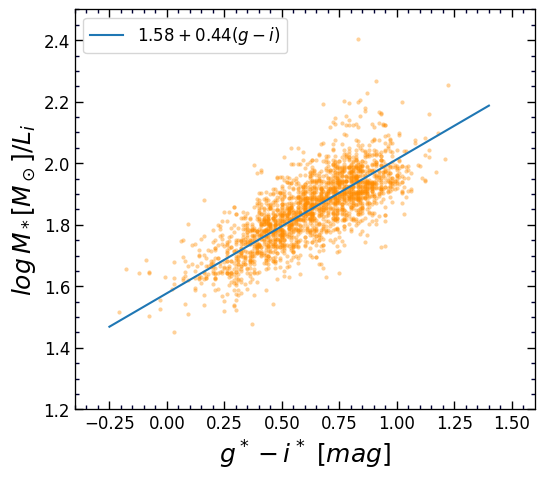

In [5]:
fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

df['logMs'] =(np.log10(0.5) + 0.4*5.91)-0.4*df['M1_75']+0.4*df['Mi_75']

dff = df[(df.Qs>2)&(df.Qw>2)&(df.logMs<10)].dropna()

X0 = dff.gi.values
Y0 = dff.logMs.values 

ax.plot(X0, Y0, 'o', alpha=0.4, ms=3, mfc='darkorange', mec='none')


set_axes(ax, (-0.4,1.6), (1.2,2.5), fontsize=12)


def func(x, m, b):
    return m*x+b
    


mcfit = lts_linefit(X0, Y0, X0*0+0.07, Y0*0+0.11*0.4, clip=3., plot=False)
m = mcfit.ab[1]
b = mcfit.ab[0]

gi = np.linspace(-0.25, 1.4)
# ax.plot(gi, 0.7*gi+1.15, 'r-', label=r'$\Upsilon^*_i=-0.68+0.70(g-i)$')
# ax.plot(gi, m0*gi+b0, 'b-', label=r'$\Upsilon_*=-0.68+0.7(g-i)$')
ax.plot(gi, m*gi+b, '-', label=r'$1.58+0.44(g-i)$', color='#1f77b4')


mask = ~mcfit.mask
xx = X0[mask]
yy = Y0[mask]

yy0 = m*xx+b
xx1 = xx[yy>yy0]
yy1 = yy[yy>yy0]
# ax.plot(xx1, yy1, 'r.', alpha=0.5)


yy0 = m*xx+b
xx1 = xx[yy<yy0]
yy1 = yy[yy<yy0]
# ax.plot(xx1, yy1, 'b.', alpha=0.5)

print(m, b)


ax.set_xlabel(r'$g^*-i^* \/\/[mag]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_*[M_\odot]/L_{i}$', fontsize=18)

ax.legend(fontsize=12)        

In [9]:
np.std(Y0 - (0.44*X0+1.58))

0.09560169415482608

Text(0, 0.5, 'number')

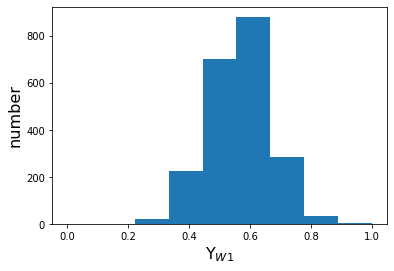

In [10]:
dff = df[(df.Qs>2)&(df.Qw>2)&(df.logMs<10)].dropna()

Ups = 1.15 + 0.7*dff.gi.values - 0.4*dff['Mi_75'] - 0.4*5.91 + 0.4*df['M1_75']
Ups = -Ups

bins = np.linspace(0,1,10)

plt.hist(Ups, bins=bins)
plt.xlabel(r"$\Upsilon_{W1}$", fontsize=16)
plt.ylabel("number", fontsize=16)


sig_int:     0.0000      0.6914
Computing sig_int
sig_int:     0.0000      0.6914
sig_int:     0.0749     -0.4305
sig_int:     0.0462     -0.0302
sig_int:     0.0441      0.0076
sig_int:     0.0445     -0.0001
sig_int:     0.0445      0.0003
Computing sig_int error
sig_int:     0.0445      0.0306
sig_int:     0.0749     -0.3998
sig_int:     0.0467     -0.0085
sig_int:     0.0462     -0.0001
sig_int:     0.0462      0.0003
Repeat at best fitting solution
sig_int:     0.0445     -0.0001
################# Values and formal errors ################
 intercept:  -0.2344 +/- 0.0045
     slope:  0.4355 +/- 0.0068
   scatter:  0.0445 +/- 0.0017
Observed rms scatter: 0.070
Spearman r=0.77 and p=0
Pearson r=0.64 and p=1e-249
##########################################################
seconds 20.83
0.4354756324131824 -0.2344419178954612


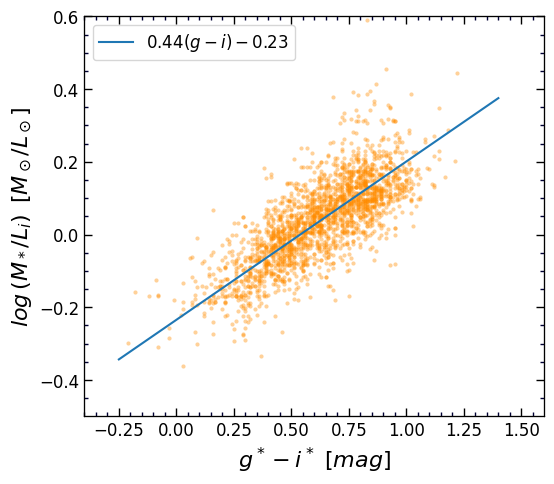

In [11]:
fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

df['logMs'] =(np.log10(0.5) + 0.4*5.91)-0.4*df['M1_75']+0.4*df['Mi_75']-0.4*4.53

dff = df[(df.Qs>2)&(df.Qw>2)&(df.logMs<10)].dropna()

X0 = dff.gi.values
Y0 = dff.logMs.values 

ax.plot(X0, Y0, 'o', alpha=0.4, ms=3, mfc='darkorange', mec='none')


set_axes(ax, (-0.4,1.6), (-0.5,0.6), fontsize=12)


def func(x, m, b):
    return m*x+b
    


mcfit = lts_linefit(X0, Y0, X0*0+0.07, Y0*0+0.11*0.4, clip=3., plot=False)
m = mcfit.ab[1]
b = mcfit.ab[0]

gi = np.linspace(-0.25, 1.4)
# ax.plot(gi, 0.7*gi+1.15, 'r-', label=r'$\Upsilon^*_i=-0.68+0.70(g-i)$')
# ax.plot(gi, m0*gi+b0, 'b-', label=r'$\Upsilon_*=-0.68+0.7(g-i)$')
ax.plot(gi, m*gi+b, '-', label=r'$0.44(g-i)-0.23$', color='#1f77b4')


mask = ~mcfit.mask
xx = X0[mask]
yy = Y0[mask]

yy0 = m*xx+b
xx1 = xx[yy>yy0]
yy1 = yy[yy>yy0]
# ax.plot(xx1, yy1, 'r.', alpha=0.5)


yy0 = m*xx+b
xx1 = xx[yy<yy0]
yy1 = yy[yy<yy0]
# ax.plot(xx1, yy1, 'b.', alpha=0.5)

print(m, b)


ax.set_xlabel(r'$g^*-i^* \/\/[mag]$', fontsize=16) 
ax.set_ylabel(r'$log \/ (M_*/L_{i}) \/\/\/ [M_\odot/L_\odot]$', fontsize=16)
# ax.set_title(r'$$')

ax.legend(fontsize=12)        

sig_int:     0.0000      0.2975
Computing sig_int
sig_int:     0.0000      0.2975
sig_int:     0.0735     -0.4928
sig_int:     0.0277      0.0739
sig_int:     0.0356     -0.0424
sig_int:     0.0327     -0.0024
sig_int:     0.0326     -0.0001
sig_int:     0.0326      0.0001
Computing sig_int error
sig_int:     0.0326      0.0306
sig_int:     0.0735     -0.4621
sig_int:     0.0351     -0.0045
sig_int:     0.0348      0.0000
sig_int:     0.0348     -0.0002
Repeat at best fitting solution
sig_int:     0.0326     -0.0001
################# Values and formal errors ################
 intercept:  1.5657 +/- 0.0045
     slope:  0.5972 +/- 0.0068
   scatter:  0.0326 +/- 0.0022
Observed rms scatter: 0.069
Spearman r=0.86 and p=0
Pearson r=0.81 and p=0
##########################################################
seconds 24.28


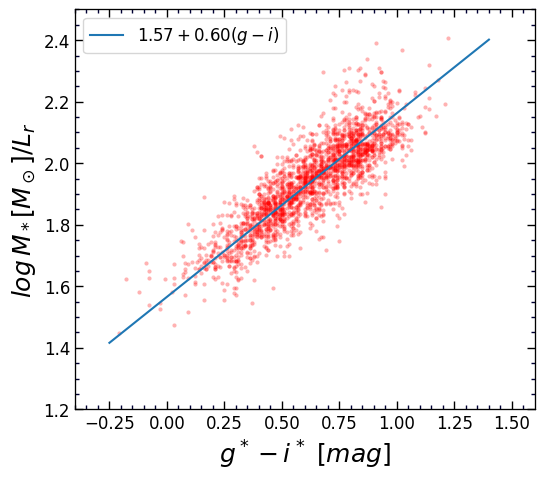

In [8]:
fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

df['logMs'] =(np.log10(0.5) + 0.4*5.91)-0.4*df['M1_75']+0.4*df['Mr_75']

dff = df[(df.Qs>2)&(df.Qw>2)&(df.logMs<10)].dropna()

X0 = dff.gi.values
Y0 = dff.logMs.values 

ax.plot(X0, Y0, 'o', alpha=0.3, ms=3, mfc='red', mec='none')


set_axes(ax, (-0.4,1.6), (1.2,2.5), fontsize=12)

mcfit = lts_linefit(X0, Y0, X0*0+0.07, Y0*0+0.11*0.4, clip=3., plot=False)
m = mcfit.ab[1]
b = mcfit.ab[0]

color = np.linspace(-0.25, 1.4)
zp = '%.2f'%b
slope = '%.2f'%m
ax.plot(color, m*color+b, '-', label=r'$'+zp+'+'+slope+'(g-i)$', color='#1f77b4')


ax.set_xlabel(r'$g^*-i^* \/\/[mag]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_*[M_\odot]/L_{r}$', fontsize=18)

ax.legend(fontsize=12)        

sig_int:     0.0000      0.2975
Computing sig_int
sig_int:     0.0000      0.2975
sig_int:     0.0735     -0.4928
sig_int:     0.0277      0.0739
sig_int:     0.0356     -0.0424
sig_int:     0.0327     -0.0024
sig_int:     0.0326     -0.0001
sig_int:     0.0326      0.0001
Computing sig_int error
sig_int:     0.0326      0.0306
sig_int:     0.0735     -0.4621
sig_int:     0.0351     -0.0045
sig_int:     0.0348      0.0000
sig_int:     0.0348     -0.0002
Repeat at best fitting solution
sig_int:     0.0326     -0.0001
################# Values and formal errors ################
 intercept:  -0.2943 +/- 0.0045
     slope:  0.5972 +/- 0.0068
   scatter:  0.0326 +/- 0.0022
Observed rms scatter: 0.069
Spearman r=0.86 and p=0
Pearson r=0.81 and p=0
##########################################################
seconds 24.21


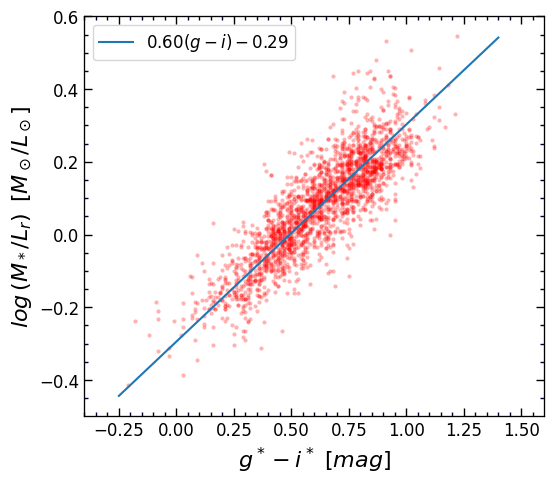

In [9]:
fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

df['logMs'] =(np.log10(0.5) + 0.4*5.91)-0.4*df['M1_75']+0.4*df['Mr_75']-0.4*4.65

dff = df[(df.Qs>2)&(df.Qw>2)&(df.logMs<10)].dropna()

X0 = dff.gi.values
Y0 = dff.logMs.values 

ax.plot(X0, Y0, 'o', alpha=0.3, ms=3, mfc='red', mec='none')


set_axes(ax, (-0.4,1.6), (-0.5,0.6), fontsize=12)

mcfit = lts_linefit(X0, Y0, X0*0+0.07, Y0*0+0.11*0.4, clip=3., plot=False)
m = mcfit.ab[1]
b = mcfit.ab[0]

color = np.linspace(-0.25, 1.4)
zp = '%.2f'%b
slope = '%.2f'%m
ax.plot(color, m*color+b, '-', label=r'$'+slope+'(g-i)'+zp+'$', color='#1f77b4')

ax.set_xlabel(r'$g^*-i^* \/\/[mag]$', fontsize=16) 
ax.set_ylabel(r'$log \/ (M_*/L_{r}) \/\/\/ [M_\odot/L_\odot]$', fontsize=16)

ax.legend(fontsize=12)        

sig_int:     0.0000      0.7947
Computing sig_int
sig_int:     0.0000      0.7947
sig_int:     0.0724     -0.4207
sig_int:     0.0473     -0.0542
sig_int:     0.0439      0.0282
sig_int:     0.0450      0.0045
sig_int:     0.0453      0.0004
sig_int:     0.0453     -0.0001
Computing sig_int error
sig_int:     0.0453      0.0307
sig_int:     0.0724     -0.3900
sig_int:     0.0473     -0.0220
sig_int:     0.0464     -0.0064
sig_int:     0.0462     -0.0010
sig_int:     0.0461     -0.0001
sig_int:     0.0461      0.0004
Repeat at best fitting solution
sig_int:     0.0453     -0.0001
################# Values and formal errors ################
 intercept:  1.5926 +/- 0.0044
     slope:  0.3511 +/- 0.0067
   scatter:  0.04528 +/- 0.00082
Observed rms scatter: 0.068
Spearman r=0.7 and p=2.1e-321
Pearson r=0.28 and p=2.2e-41
##########################################################
seconds 27.49


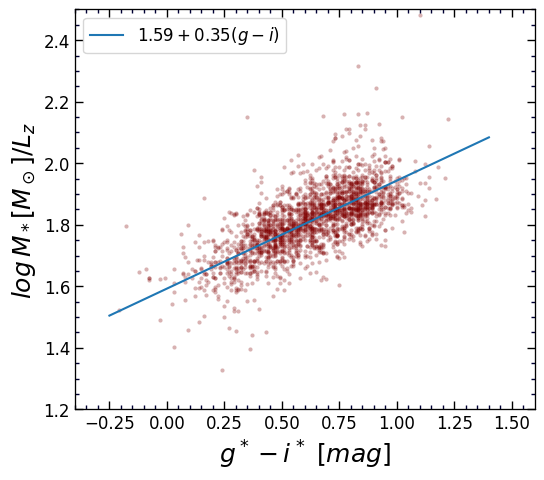

In [10]:
fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

df['logMs'] =(np.log10(0.5) + 0.4*5.91)-0.4*df['M1_75']+0.4*df['Mz_75']

dff = df[(df.Qs>2)&(df.Qw>2)&(df.logMs<10)].dropna()

X0 = dff.gi.values
Y0 = dff.logMs.values 

ax.plot(X0, Y0, 'o', alpha=0.3, ms=3, mfc='maroon', mec='none')


set_axes(ax, (-0.4,1.6), (1.2,2.5), fontsize=12)

mcfit = lts_linefit(X0, Y0, X0*0+0.07, Y0*0+0.11*0.4, clip=3., plot=False)
m = mcfit.ab[1]
b = mcfit.ab[0]

color = np.linspace(-0.25, 1.4)
zp = '%.2f'%b
slope = '%.2f'%m
ax.plot(color, m*color+b, '-', label=r'$'+zp+'+'+slope+'(g-i)$', color='#1f77b4')


ax.set_xlabel(r'$g^*-i^* \/\/[mag]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_*[M_\odot]/L_{z}$', fontsize=18)

ax.legend(fontsize=12)        

sig_int:     0.0000      0.7947
Computing sig_int
sig_int:     0.0000      0.7947
sig_int:     0.0724     -0.4207
sig_int:     0.0473     -0.0542
sig_int:     0.0439      0.0282
sig_int:     0.0450      0.0045
sig_int:     0.0453      0.0004
sig_int:     0.0453     -0.0001
Computing sig_int error
sig_int:     0.0453      0.0307
sig_int:     0.0724     -0.3900
sig_int:     0.0473     -0.0220
sig_int:     0.0464     -0.0064
sig_int:     0.0462     -0.0010
sig_int:     0.0461     -0.0001
sig_int:     0.0461      0.0004
Repeat at best fitting solution
sig_int:     0.0453     -0.0001
################# Values and formal errors ################
 intercept:  -0.2074 +/- 0.0044
     slope:  0.3511 +/- 0.0067
   scatter:  0.04528 +/- 0.00082
Observed rms scatter: 0.068
Spearman r=0.7 and p=2.1e-321
Pearson r=0.28 and p=2.2e-41
##########################################################
seconds 27.00


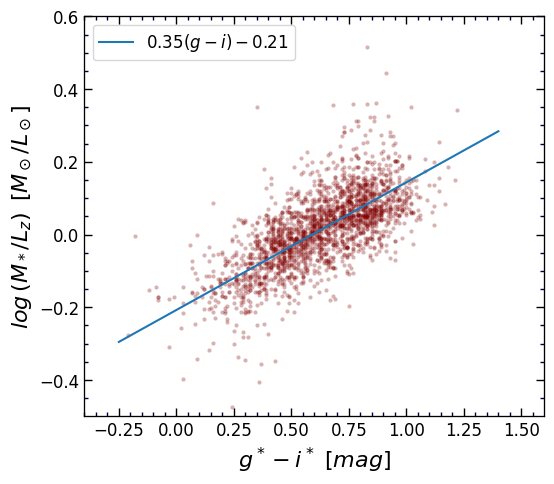

In [11]:
fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

df['logMs'] =(np.log10(0.5) + 0.4*5.91)-0.4*df['M1_75']+0.4*df['Mz_75']-0.4*4.50

dff = df[(df.Qs>2)&(df.Qw>2)&(df.logMs<10)].dropna()

X0 = dff.gi.values
Y0 = dff.logMs.values 

ax.plot(X0, Y0, 'o', alpha=0.3, ms=3, mfc='maroon', mec='none')


set_axes(ax, (-0.4,1.6), (-0.5,0.6), fontsize=12)

mcfit = lts_linefit(X0, Y0, X0*0+0.07, Y0*0+0.11*0.4, clip=3., plot=False)
m = mcfit.ab[1]
b = mcfit.ab[0]

color = np.linspace(-0.25, 1.4)
zp = '%.2f'%b
slope = '%.2f'%m
ax.plot(color, m*color+b, '-', label=r'$'+slope+'(g-i)'+zp+'$', color='#1f77b4')

ax.set_xlabel(r'$g^*-i^* \/\/[mag]$', fontsize=16) 
ax.set_ylabel(r'$log \/ (M_*/L_{z}) \/\/\/ [M_\odot/L_\odot]$', fontsize=16)

ax.legend(fontsize=12)        

In [14]:
def panelPlot(ax1, ax2, dff, color='black', xlabel=None, ylabel=None, legend=True, band=None):
    
    X0 = dff.gi.values
    Y0 = dff.logMs.values 

    ax1.plot(X0, Y0, 'o', alpha=0.15, ms=3, mfc=color, mec='none')


    set_axes(ax1, (-0.3,1.3), (-0.5,0.6), fontsize=12)
    set_axes(ax2, (-0.3,1.3), (-0.4,0.4), fontsize=12)

    mcfit = lts_linefit(X0, Y0, X0*0+0.07, Y0*0+0.11*0.4, clip=3., plot=False)
    m = mcfit.ab[1]
    b = mcfit.ab[0]

    gi_color = np.linspace(-0.20, 1.20)
    zp = '%.2f'%b
    slope = '%.2f'%m
    ax1.plot(gi_color, m*gi_color+b, '-', label=r'$'+slope+'(g-i)'+zp+'$', color='#1f77b4')
    
    if band is not None:
        ax1.text(-0.2, 0.2, band, color='k', fontsize=14)
    
    if xlabel is not None:
        ax2.set_xlabel(xlabel, fontsize=14) 
    
    if ylabel is not None:
        ax1.set_ylabel(ylabel, fontsize=14)
        ax2.set_ylabel('residuals', fontsize=14)
    else:
        plt.setp(ax2.get_yticklabels(), visible=False)
        plt.setp(ax1.get_yticklabels(), visible=False)
    
    if legend:
        ax1.legend(fontsize=12)
        
    ax2.plot(X0, Y0-(m*X0+b), 'o', alpha=0.15, ms=3, mfc=color, mec='none')
    
    ax2.plot([-0.3,1.3],[0,0], ':', color='#1f77b4')
    
    ax2.text(-0.2,-0.25, 'rms = '+ '%.2f'%mcfit.rms, fontsize=14)
    
    xe = [0.05*np.sqrt(2.)]
    ye = [np.sqrt((0.2/np.log(10.))**2 + 2*0.05**2 + (0.4*0.05*np.sqrt(2.))**2)]
    ax1.errorbar([1.1],[-0.30], xerr=xe, yerr=ye, fmt='o', 
                    color=color, ms=4, capsize=3, mfc=color)
    
    return mcfit

sig_int:     0.0000      0.2975
Computing sig_int
sig_int:     0.0000      0.2975
sig_int:     0.0735     -0.4928
sig_int:     0.0277      0.0739
sig_int:     0.0356     -0.0424
sig_int:     0.0327     -0.0024
sig_int:     0.0326     -0.0001
sig_int:     0.0326      0.0001
Computing sig_int error
sig_int:     0.0326      0.0306
sig_int:     0.0735     -0.4621
sig_int:     0.0351     -0.0045
sig_int:     0.0348      0.0000
sig_int:     0.0348     -0.0002
Repeat at best fitting solution
sig_int:     0.0326     -0.0001
################# Values and formal errors ################
 intercept:  -0.2943 +/- 0.0045
     slope:  0.5972 +/- 0.0068
   scatter:  0.0326 +/- 0.0022
Observed rms scatter: 0.069
Spearman r=0.86 and p=0
Pearson r=0.81 and p=0
##########################################################
seconds 24.17
sig_int:     0.0000      0.6914
Computing sig_int
sig_int:     0.0000      0.6914
sig_int:     0.0749     -0.4305
sig_int:     0.0462     -0.0302
sig_int:     0.0441      0.007

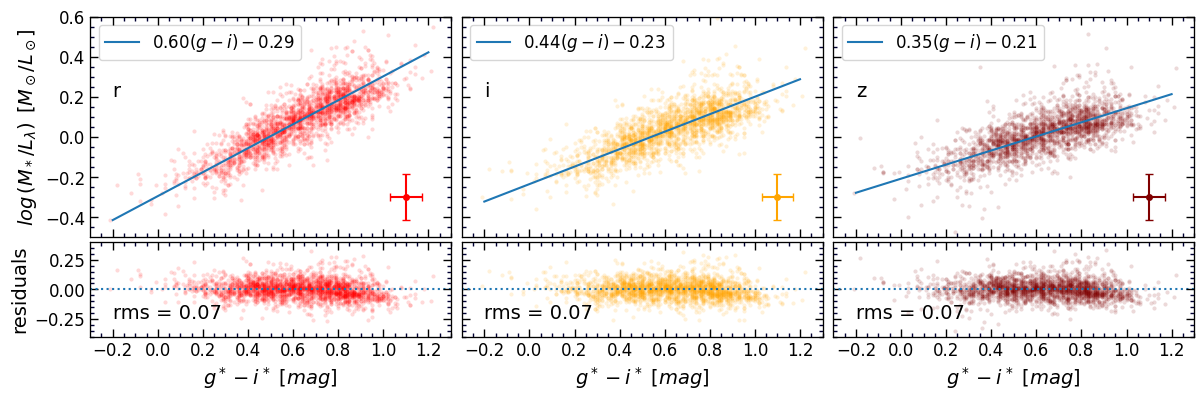

In [15]:
fig = py.figure(figsize=(12,4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
nrows = 2
ncols = 3
gs = gridspec.GridSpec(nrows, ncols, height_ratios = [0.7, 0.3])


df['logMs'] =(np.log10(0.5) + 0.4*5.91)-0.4*df['M1_75']+0.4*df['Mr_75']-0.4*4.65
dff = df[(df.Qs>2)&(df.Qw>2)&(df.logMs<10)].dropna()
mcfit = panelPlot(plt.subplot(gs[0]), \
          plt.subplot(gs[3]), \
          dff, \
          color='red', \
          ylabel=r'$log \/ (M_*/L_{\lambda}) \/\/\/ [M_\odot/L_\odot]$', \
          xlabel  = r'$g^*-i^* \/\/[mag]$', \
          band = 'r'
         )


df['logMs'] =(np.log10(0.5) + 0.4*5.91)-0.4*df['M1_75']+0.4*df['Mi_75']-0.4*4.53
dff = df[(df.Qs>2)&(df.Qw>2)&(df.logMs<10)].dropna()
panelPlot(plt.subplot(gs[1]), \
          plt.subplot(gs[4]), dff, \
          color='orange', \
          xlabel  = r'$g^*-i^* \/\/[mag]$', \
          band = 'i'
         )


df['logMs'] =(np.log10(0.5) + 0.4*5.91)-0.4*df['M1_75']+0.4*df['Mz_75']-0.4*4.50
dff = df[(df.Qs>2)&(df.Qw>2)&(df.logMs<10)].dropna()
panelPlot(plt.subplot(gs[2]), \
          plt.subplot(gs[5]), dff, \
          color  = 'maroon', \
          xlabel  = r'$g^*-i^* \/\/[mag]$', \
          band = 'z'
         )


plt.subplots_adjust(hspace=0.03, wspace=0.03)

In [98]:
df.Vmod

0        4786
1        4154
2        6297
3        5387
4        4507
         ... 
10732    2228
10733    2833
10734    2752
10735    7005
10736    4745
Name: Vmod, Length: 10654, dtype: int64

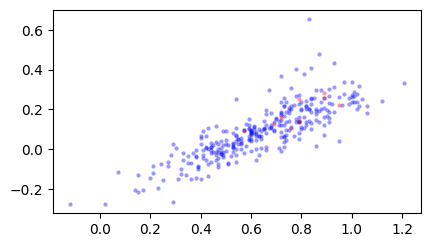

In [102]:
fig = py.figure(figsize=(12,4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
nrows = 2
ncols = 3
gs = gridspec.GridSpec(nrows, ncols, height_ratios = [0.7, 0.3])

ax1 = plt.subplot(gs[0])


df['logMs'] =(np.log10(0.5) + 0.4*5.91)-0.4*df['M1_75']+0.4*df['Mr_75']-0.4*4.65
dff = df[(df.Qs>2)&(df.Qw>2)&(df.logMs<10)&(df.Vmod>4000)&(df.Vmod<5000)].dropna()  
X0 = dff.gi.values
Y0 = dff.logMs.values 
ax1.plot(X0, Y0, 'o', alpha=0.4, ms=3, mfc='b', mec='none')



df['logMs'] =(np.log10(0.5) + 0.4*5.91)-0.4*df['M1_75']+0.4*df['Mr_75']-0.4*4.65
dff = df[(df.Qs>2)&(df.Qw>2)&(df.logMs<10)&(df.Vmod>15000)].dropna()
X0 = dff.gi.values
Y0 = dff.logMs.values 
ax1.plot(X0, Y0, 'o', alpha=0.4, ms=3, mfc='r', mec='none')

sig_int:     0.0000     -0.1951
No intrinsic scatter or errors overestimated
Repeat at best fitting solution
sig_int:     0.0000     -0.1951
################# Values and formal errors ################
 intercept:  1.5221 +/- 0.0058
     slope:  1.038 +/- 0.014
   scatter:  0. +/- 0.0
Observed rms scatter: 0.076
Spearman r=0.85 and p=0
Pearson r=0.85 and p=0
##########################################################
seconds 3.71


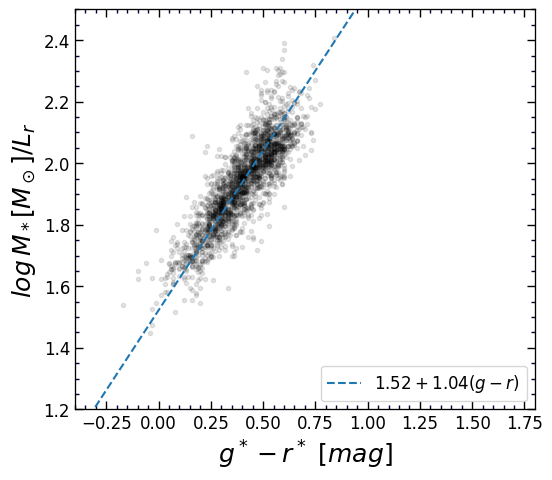

In [12]:
fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

df['logMs'] =(np.log10(0.5) + 0.4*5.91)-0.4*df['M1_75']+0.4*df['Mr_75']

dff = df[(df.Qs>2)&(df.Qw>2)&(df.logMs<10)].dropna()

X0 = dff.gr.values
Y0 = dff.logMs.values 

ax.plot(X0, Y0, 'k.', alpha=0.1)


set_axes(ax, (-0.4,1.8), (1.2,2.5), fontsize=12)

mcfit = lts_linefit(X0, Y0, X0*0+0.07, Y0*0+0.11*0.4, clip=3., plot=False)
m = mcfit.ab[1]
b = mcfit.ab[0]

color = np.linspace(-1,2)
zp = '%.2f'%b
slope = '%.2f'%m
ax.plot(color, m*color+b, '--', label=r'$'+zp+'+'+slope+'(g-r)$')


ax.set_xlabel(r'$g^*-r^* \/\/[mag]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_*[M_\odot]/L_{r}$', fontsize=18)

ax.legend(fontsize=12)        

sig_int:     0.0000      1.1033
Computing sig_int
sig_int:     0.0000      1.1033
sig_int:     0.0732     -0.3661
sig_int:     0.0550     -0.0853
sig_int:     0.0498      0.0147
sig_int:     0.0506     -0.0013
sig_int:     0.0505     -0.0000
sig_int:     0.0505      0.0005
Computing sig_int error
sig_int:     0.0505      0.0308
sig_int:     0.0732     -0.3353
sig_int:     0.0524     -0.0084
sig_int:     0.0520     -0.0001
sig_int:     0.0520      0.0004
Repeat at best fitting solution
sig_int:     0.0505     -0.0000
################# Values and formal errors ################
 intercept:  1.6249 +/- 0.0043
     slope:  0.2604 +/- 0.0056
   scatter:  0.0505 +/- 0.0015
Observed rms scatter: 0.069
Spearman r=0.66 and p=7.2e-275
Pearson r=-0.68 and p=5.1e-291
##########################################################
seconds 21.60


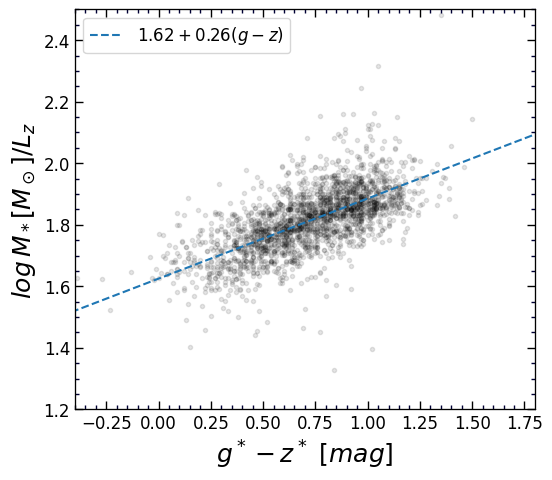

In [13]:
fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1


df['logMs'] =(np.log10(0.5) + 0.4*5.91)-0.4*df['M1_75']+0.4*df['Mz_75']

dff = df[(df.Qs>2)&(df.Qw>2)&(df.logMs<10)].dropna()

X0 = dff.gz.values
Y0 = dff.logMs.values 

ax.plot(X0, Y0, 'k.', alpha=0.1)

set_axes(ax, (-0.4,1.8), (1.2,2.5), fontsize=12)


mcfit = lts_linefit(X0, Y0, X0*0+0.07, Y0*0+0.11*0.4, clip=3., plot=False)
m = mcfit.ab[1]
b = mcfit.ab[0]

color = np.linspace(-1,2)
zp = '%.2f'%b
slope = '%.2f'%m
ax.plot(color, m*color+b, '--', label=r'$'+zp+'+'+slope+'(g-z)$')


ax.set_xlabel(r'$g^*-z^* \/\/[mag]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_*[M_\odot]/L_{z}$', fontsize=18)

ax.legend(fontsize=12)        

sig_int:     0.0000      0.1722
Computing sig_int
sig_int:     0.0000      0.1722
sig_int:     0.0876     -0.5678
sig_int:     0.0204      0.0821
sig_int:     0.0366     -0.0713
sig_int:     0.0291      0.0062
sig_int:     0.0297      0.0006
sig_int:     0.0297      0.0000
sig_int:     0.0298     -0.0001
Computing sig_int error
sig_int:     0.0297      0.0307
sig_int:     0.0876     -0.5370
sig_int:     0.0329      0.0006
sig_int:     0.0329     -0.0000
sig_int:     0.0329      0.0001
Repeat at best fitting solution
sig_int:     0.0297      0.0000
################# Values and formal errors ################
 intercept:  1.5819 +/- 0.0047
     slope:  0.850 +/- 0.014
   scatter:  0.0297 +/- 0.0032
Observed rms scatter: 0.080
Spearman r=0.73 and p=0
Pearson r=0.16 and p=2.8e-14
##########################################################
seconds 29.55


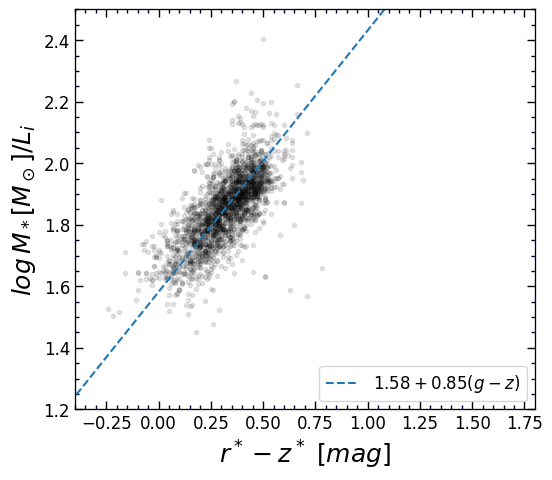

In [14]:
fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1


df['logMs'] =(np.log10(0.5) + 0.4*5.91)-0.4*df['M1_75']+0.4*df['Mi_75']

dff = df[(df.Qs>2)&(df.Qw>2)&(df.logMs<10)].dropna()

X0 = dff.rz.values
Y0 = dff.logMs.values 

ax.plot(X0, Y0, 'k.', alpha=0.1)

set_axes(ax, (-0.4,1.8), (1.2,2.5), fontsize=12)


mcfit = lts_linefit(X0, Y0, X0*0+0.07, Y0*0+0.11*0.4, clip=3., plot=False)
m = mcfit.ab[1]
b = mcfit.ab[0]

color = np.linspace(-1,2)
zp = '%.2f'%b
slope = '%.2f'%m
ax.plot(color, m*color+b, '--', label=r'$'+zp+'+'+slope+'(g-z)$')


ax.set_xlabel(r'$r^*-z^* \/\/[mag]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_*[M_\odot]/L_{i}$', fontsize=18)

ax.legend(fontsize=12)        

sig_int:     0.0000     -0.3915
No intrinsic scatter or errors overestimated
Repeat at best fitting solution
sig_int:     0.0000     -0.3915
################# Values and formal errors ################
 intercept:  -0.0322 +/- 0.0026
     slope:  0.5742 +/- 0.0042
   scatter:  0. +/- 0.0
Observed rms scatter: 0.063
Spearman r=0.85 and p=0
Pearson r=0.32 and p=1.9e-174
##########################################################
seconds 6.53


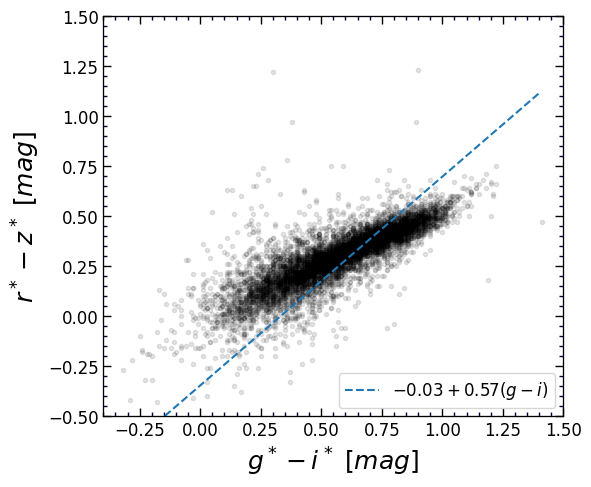

In [15]:
fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1


dff = df[(df.Qs>2)&(df.logMs<10)].dropna()

X0 = dff.gi.values
Y0 = dff.rz.values 

ax.plot(X0, Y0, 'k.', alpha=0.1)

set_axes(ax, (-0.4,1.5), (-0.5,1.5), fontsize=12)


mcfit = lts_linefit(X0, Y0, X0*0+0.07, Y0*0+0.07, clip=3., plot=False)
m = mcfit.ab[1]
b = mcfit.ab[0]

color = np.linspace(-1,2)
zp = '%.2f'%b
slope = '%.2f'%m
ax.plot(gi, m*color+b, '--', label=r'$'+zp+'+'+slope+'(g-i)$')


ax.set_xlabel(r'$g^*-i^* \/\/[mag]$', fontsize=18) 
ax.set_ylabel(r'$r^*-z^* \/\/[mag]$', fontsize=18) 

ax.legend(fontsize=12) 

In [16]:
len(X0)

7378

sig_int:     0.0000     -0.1951
No intrinsic scatter or errors overestimated
Repeat at best fitting solution
sig_int:     0.0000     -0.1951
################# Values and formal errors ################
 intercept:  1.5221 +/- 0.0058
     slope:  1.038 +/- 0.014
   scatter:  0. +/- 0.0
Observed rms scatter: 0.076
Spearman r=0.85 and p=0
Pearson r=0.85 and p=0
##########################################################
seconds 3.68


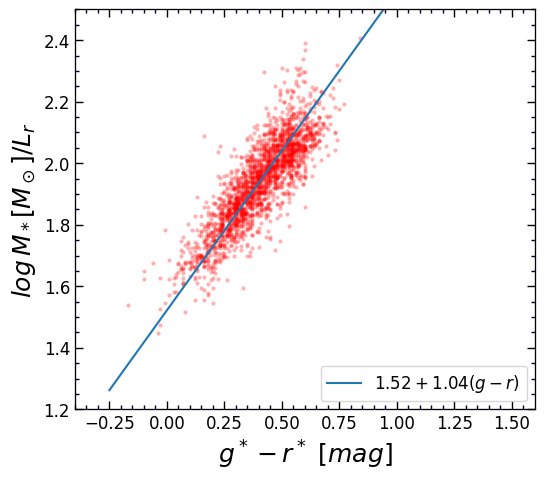

In [17]:
fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

df['logMs'] =(np.log10(0.5) + 0.4*5.91)-0.4*df['M1_75']+0.4*df['Mr_75']

dff = df[(df.Qs>2)&(df.Qw>2)&(df.logMs<10)].dropna()

X0 = dff.gr.values
Y0 = dff.logMs.values 

ax.plot(X0, Y0, 'o', alpha=0.3, ms=3, mfc='red', mec='none')


set_axes(ax, (-0.4,1.6), (1.2,2.5), fontsize=12)

mcfit = lts_linefit(X0, Y0, X0*0+0.07, Y0*0+0.11*0.4, clip=3., plot=False)
m = mcfit.ab[1]
b = mcfit.ab[0]

color = np.linspace(-0.25, 1.4)
zp = '%.2f'%b
slope = '%.2f'%m
ax.plot(color, m*color+b, '-', label=r'$'+zp+'+'+slope+'(g-r)$', color='#1f77b4')


ax.set_xlabel(r'$g^*-r^* \/\/[mag]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_*[M_\odot]/L_{r}$', fontsize=18)

ax.legend(fontsize=12)        

sig_int:     0.0000     -0.5232
No intrinsic scatter or errors overestimated
Repeat at best fitting solution
sig_int:     0.0000     -0.5232
################# Values and formal errors ################
 intercept:  -0.5043 +/- 0.0072
     slope:  1.395 +/- 0.017
   scatter:  0. +/- 0.0
Observed rms scatter: 0.074
Spearman r=0.92 and p=0
Pearson r=0.92 and p=0
##########################################################
seconds 3.47


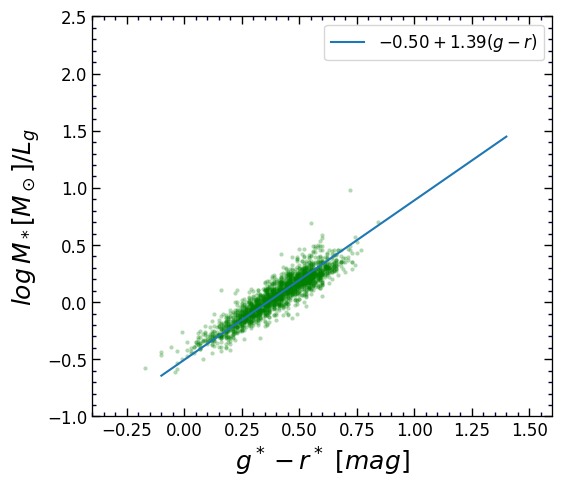

In [18]:
fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

df['logMs'] =(np.log10(0.5) + 0.4*5.91)-0.4*df['M1_75']+0.4*df['Mg_75']-0.4*5.11

dff = df[(df.Qs>2)&(df.Qw>2)&(df.logMs<10)].dropna()

X0 = dff.gr.values
Y0 = dff.logMs.values 

ax.plot(X0, Y0, 'o', alpha=0.3, ms=3, mfc='green', mec='none')


set_axes(ax, (-0.4,1.6), (-1,2.5), fontsize=12)

mcfit = lts_linefit(X0, Y0, X0*0+0.07, Y0*0+0.11*0.4, clip=3., plot=False)
m = mcfit.ab[1]
b = mcfit.ab[0]

color = np.linspace(-0.1, 1.4)
zp = '%.2f'%b
slope = '%.2f'%m
ax.plot(color, m*color+b, '-', label=r'$'+zp+'+'+slope+'(g-r)$', color='#1f77b4')


ax.set_xlabel(r'$g^*-r^* \/\/[mag]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_*[M_\odot]/L_{g}$', fontsize=18)

ax.legend(fontsize=12)        